Downloaded data!
Training model
Epoch #1, train loss: 0.75097221431847, eval acc: 0.9277777671813965
Epoch #2, train loss: 0.18891330755093205, eval acc: 0.9351851940155029
Epoch #3, train loss: 0.11786071499338067, eval acc: 0.949999988079071
Epoch #4, train loss: 0.08850294760357635, eval acc: 0.9759259223937988
Epoch #5, train loss: 0.06707957367003083, eval acc: 0.9648148417472839
Epoch #6, train loss: 0.043317473140770654, eval acc: 0.9685184955596924
Epoch #7, train loss: 0.022566711750394323, eval acc: 0.9759259223937988
Epoch #8, train loss: 0.019117831588904597, eval acc: 0.9777777791023254
Epoch #9, train loss: 0.013082167451774625, eval acc: 0.9759259223937988
Epoch #10, train loss: 0.01942078789220489, eval acc: 0.9740740656852722
Model is trained!
Attacking...
Eval acc after attack: 0.9203703703703704
Successful attacks: 29


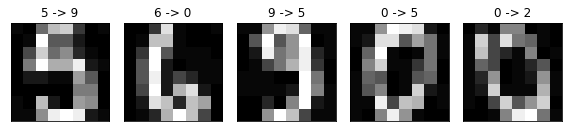

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import load_digits

DEVICE = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_seq = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv_seq(x)
        x = self.fc1(torch.flatten(x, 1))
        return x

    def predict(self, x):
        with torch.no_grad():
            if len(x.shape) < 4:
                x = torch.unsqueeze(x, 0)
            res = torch.argmax(self.forward(x), dim=1)
        return res


def create_datasets():
    X, y = load_digits(return_X_y=True)
    X = X.reshape((-1, 8, 8, 1)).transpose(0, 3, 2, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    dataset = TensorDataset(torch.Tensor(X_train), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

    dataset = TensorDataset(torch.Tensor(X_test), torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    return train_loader, test_loader


def eval(model, test_loader):
    with torch.no_grad():
        total = 0
        correct_preds = 0
        for X, y in test_loader:
            y_hat = model.predict(X)
            correct_preds += torch.count_nonzero(y_hat == y)
            total += len(y)

    return correct_preds / total


def train_model(model, train_loader, test_loader, n_epoch=20):
    optimizer = optim.Adam(params=model.parameters())
    for ep in range(n_epoch):
        train_loss = 0
        batches = 0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            y_hat = model(X)
            loss = nn.functional.cross_entropy(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            batches += 1

        train_loss /= batches
        eval_acc = eval(model, test_loader)
        print(f'Epoch #{ep + 1}, train loss: {train_loss}, eval acc: {eval_acc}')


def run_attack(model, test_loader, eps=0.01):
    correct = 0
    adv_ex = []
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        X.requires_grad = True

        y_hat = model(X)
        loss = nn.functional.cross_entropy(y_hat, y)

        model.zero_grad()
        loss.backward()

        init_pred = torch.flatten(torch.argmax(y_hat, dim=1)).item()
        if init_pred != y.item():
            continue

        X_grad = X.grad.data

        with torch.no_grad():
            X_new = X + eps * torch.sign(X_grad)
            X_new = torch.clip(X_new, 0, 255)

            new_pred = model.predict(X_new)

        if new_pred.item() == y.item():
            correct += 1
        else:
            adv_ex.append((init_pred, new_pred.item(), X_new.numpy().squeeze(0).transpose(2, 1, 0)))

    eval_acc = correct / len(test_loader)
    print(f'Eval acc after attack: {eval_acc}')
    print(f'Successful attacks: {len(adv_ex)}')

    return adv_ex


def plot_ex(examples, n_ex=5):
    cnt = 0
    examples = examples[:n_ex]
    plt.figure(figsize=(8, 10))
    for j in range(len(examples)):
        cnt += 1
        plt.subplot(1, len(examples), j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        orig, adv, ex = examples[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()


def main():
    train_loader, test_loader = create_datasets()
    print('Downloaded data!')

    model = Net().to(DEVICE)

    print('Training model')
    train_model(model, train_loader, test_loader, n_epoch=10)
    print('Model is trained!')

    print('Attacking...')
    adv_ex = run_attack(model, test_loader, eps=0.5)

    plot_ex(adv_ex, n_ex=5)


if __name__ == "__main__":
    main()
